<a href="https://colab.research.google.com/github/marrs-lab/ocean_color/blob/main/ocean_color_index_recreating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NASA Color Index from NOMAD

This notebook recreates the color index from Hu et al's paper *Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on three‐band reflectance difference*. https://doi.org/10.1029/2011JC007395.

Author of this notebook is Patrick Gray (patrick.c.gray@duke.edu) at the Duke University Marine Lab in the Marine Robotics and Remote Sensing Lab (http://marineuas.net/).

In [ ]:
# all data from NOMAD https://seabass.gsfc.nasa.gov/wiki/NOMAD

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

Pull in the NOMAD dataset

This is just the NOMAD dataset but with all the header removed except the column names

In [14]:
df = pd.read_csv('https://seabass.gsfc.nasa.gov/wiki/NOMAD/nomad_seabass_v2.a_2008200.txt', skiprows=list(range(0,88)) + [89,90])
df = df.rename(columns={'/fields=year': 'year'})

print(df.shape)
df.head()

(4459, 217)


,year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd455,kd465,kd489,kd510,kd520,kd530,kd550,kd555,kd560,kd565,kd570,kd590,kd619,kd625,kd665,kd670,kd683,lw405,lw411,lw443,lw455,lw465,lw489,lw510,...,bbr510,bbr514,bbr532,bbr550,bbr555,bbr589,bbr620,bbr671,bbr676,bbr870,wt,sal,poc,kpar,z_37,z_10,z_01,chlide_a,mv_chl_a,dv_chl_a,chl_c3,chl_c2,chl_c1c2,perid,but-fuco,hex-fuco,fuco,pras,viola,diadino,allo,diato,lut,zea,chl_b,beta-car,alpha-car,alpha-beta-car,flag,cruise
0,2003,4,15,15,15,0,38.4279,-76.61,1565,3.70,0.0,38.19,-999.0,-999.0,3.9455,3.1457,2.9253,-999.0,2.1736,1.8802,-999.0,1.5514,-999.0,1.2106,-999.0,1.1004,-999.0,1.0474,-999.0,1.2063,-999.0,1.7324,1.6464,-999.0,0.129962,0.204331,0.299114,-999.0,0.452029,0.541019,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
1,2003,4,15,16,50,0,38.3680,-76.50,1566,3.70,0.0,35.01,-999.0,-999.0,2.5637,2.0529,1.8386,-999.0,1.4397,1.2342,-999.0,1.0148,-999.0,0.8371,-999.0,0.7567,-999.0,0.7277,-999.0,0.9150,-999.0,1.3909,1.3261,-999.0,0.120886,0.177228,0.242677,-999.0,0.315395,0.352306,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
2,2003,4,15,17,50,0,38.3074,-76.44,1567,3.70,1.0,26.91,-999.0,-999.0,2.1533,1.7531,1.6641,-999.0,1.2676,1.0893,-999.0,0.9170,-999.0,0.7240,-999.0,0.6587,-999.0,0.6482,-999.0,0.8208,-999.0,1.2360,1.1967,-999.0,0.111049,0.151807,0.192820,-999.0,0.269218,0.326515,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
3,2003,4,17,18,15,0,38.6367,-76.32,1568,3.70,3.0,47.96,-999.0,-999.0,2.6900,2.2985,2.1297,-999.0,1.6130,1.4441,-999.0,1.2004,-999.0,0.9776,-999.0,0.8857,-999.0,0.8577,-999.0,1.0546,-999.0,1.5950,1.5343,-999.0,0.051578,0.066430,0.092185,-999.0,0.121242,0.148580,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
4,2003,7,21,18,27,0,38.3047,-76.44,1559,22.03,1.0,23.55,-999.0,-999.0,3.0950,2.3966,2.1689,-999.0,1.6452,1.3757,-999.0,1.1533,-999.0,0.9311,-999.0,0.8597,-999.0,0.8625,-999.0,1.0355,-999.0,1.2731,1.2541,-999.0,0.056001,0.068530,0.090152,-999.0,0.108838,0.132581,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0302


Assign the specific wavelengths we'll be using

In [15]:
blue_lw =   'lw443'
blue_es =   'es443'
blue_rrs =  'rrs443'

green_lw =  'lw555'
green_es =  'es555'
green_rrs = 'rrs555'

red_lw =    'lw670'
red_es =    'es670'
red_rrs =   'rrs670'



This is a function that creates a new column called 'chl_merged' that uses both HPLC and flu but prioritizes HPLC when available. The Hu et al paper only uses HPLC chla data which is the default here but it is nice to have both for experimenting.


In [17]:
def chl_fcn(row):
   if row['chl_a'] != -999 :
      return (row['chl_a']) # HPLC
   else:
     return (row['chl']) # flu

df['chl_merge'] = df.apply(lambda row: chl_fcn(row), axis=1)

# whether to use only HPLC or merged chl
# Hu et al 2012 only use HPLC which is chl_a
chl = 'chl_a' # 'chl_merge'

Filter the data to match Hu et al 2012 

In [18]:
# make a copy to subset
df_chl = df.copy()

# create the rrs columns
df_chl[blue_rrs] = df_chl[blue_lw]/df_chl[blue_es]
df_chl[green_rrs] = df_chl[green_lw]/df_chl[green_es]
df_chl[red_rrs] = df_chl[red_lw]/df_chl[red_es]

# subset to delete any measurements that are missing
# filter to ensure all the SeaWiFS bands are present
df_chl = df_chl[df_chl['lw443'] != -999]
df_chl = df_chl[df_chl['lw555'] != -999]
df_chl = df_chl[df_chl['lw670'] != -999]
df_chl = df_chl[df_chl['es443'] != -999]
df_chl = df_chl[df_chl['es555'] != -999]
df_chl = df_chl[df_chl['es670'] != -999]
df_chl = df_chl[df_chl['lat'] != -999]
df_chl = df_chl[df_chl['etopo2'] != -999]
df_chl = df_chl[df_chl['lw411'] != -999]
df_chl = df_chl[df_chl['es411'] != -999]
df_chl = df_chl[df_chl['lw489'] != -999]
df_chl = df_chl[df_chl['es489'] != -999]
df_chl = df_chl[df_chl['lw510'] != -999]
df_chl = df_chl[df_chl['es510'] != -999]

df_chl = df_chl[df_chl[chl] != -999]

# subset to only rows that were deeper than 30m
df_chl = df_chl[df_chl['etopo2'] > 30]

# subset to lat between 60N and 60S
df_chl = df_chl[(df_chl['lat'] < 60) & (df_chl['lat'] > -60)]

print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  136


In [19]:
# there is one row that has a red Rrs of 0 which was suspicious but I assume just too low for the instrument to measure
df_chl[df_chl[red_rrs] <= 0.0][[red_es, red_lw, green_lw, blue_lw, chl]]

,es670,lw670,lw555,lw443,chl_a
1125,93.047,0.0,0.0966,0.5361,0.134


### Where are these measurements?

Pull in geopandas to make plotting on a world map easier.

In [ ]:
! pip install geopandas

Text(0.5, 1.0, 'HPLC chla locations for algorithm development')

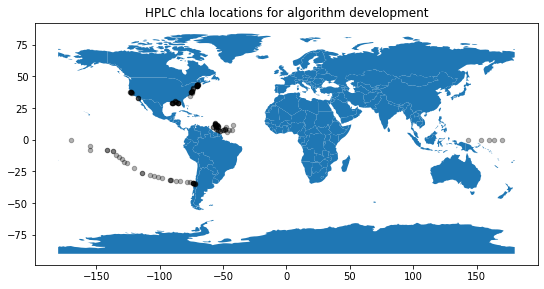

In [53]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df_chl, geometry=gpd.points_from_xy(x=df_chl.lon, y=df_chl.lat)
)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(9,14))
world.plot(ax=ax)
gdf.plot(color='black',markersize=20,alpha=.3,ax=ax)
ax.set_title('HPLC chla locations for algorithm development')

### Calculate the Color Index

In [22]:
CI = df_chl[green_rrs] - ((df_chl[blue_rrs]) + (555 - 443)/(670 - 443) * (df_chl[red_rrs] - df_chl[blue_rrs]))

Make a plot that looks roughly like figure 3b from Hu et al



Text(0, 0.5, 'chl_a')

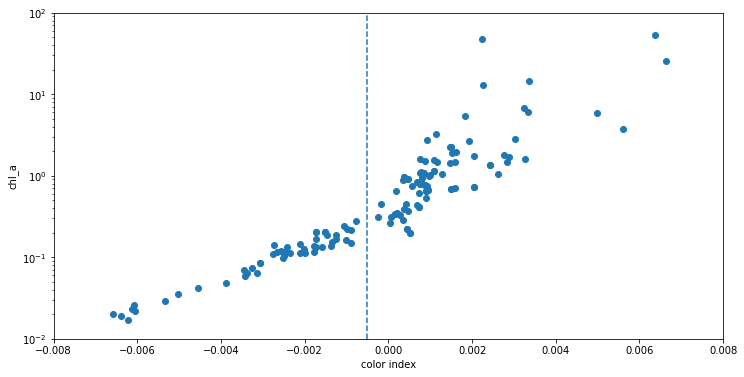

In [44]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(CI, df_chl[chl])
ax.set_xlim(-0.008,.008)
ax.axvline(-.0005, linestyle='--') # this is the cutoff the paper uses for the CI
ax.set_ylim(0.01, 100)
ax.set_yscale('log')
ax.set_xlabel('color index')
ax.set_ylabel(chl)

Cut out all rows that have a color index above -0.0005

In [24]:
CI_subset = np.array(CI[CI <= -0.0005])
chla_subset = np.array(df_chl[CI <= -0.0005][chl])

# how many do we have after this subsetting?
CI_subset.shape

(50,)

Log transform chlorophyll

In [25]:
log_chla_subset = np.log10(chla_subset)

### Run linear and nonlinear regressions

Linear

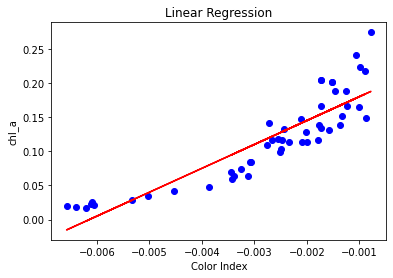

In [45]:
x = CI_subset
y = chla_subset

# Fitting Linear Regression to the dataset 
from sklearn.linear_model import LinearRegression 
lin = LinearRegression() 

lin.fit(x.reshape(-1,1), y) 

y_pred = lin.predict(x.reshape(-1,1))

# Visualising the Linear Regression results 
plt.scatter(x, y, color = 'blue') 
  
plt.plot(x, y_pred, color = 'red') 
plt.title('Linear Regression') 
plt.xlabel('Color Index') 
plt.ylabel(chl) 
  
plt.show() 

In [46]:
lin.intercept_, lin.coef_

(0.21532765396239648, array([35.04891849]))

In [47]:
r2 = r2_score(y, y_pred)
rms = np.sqrt(np.mean(np.square(((y - y_pred) / y)), axis=0))

print('R2 = ', r2)
print('RMS = ', rms)

R2 =  0.7842489078333545
RMS =  0.4942163244893365


Nonlinear Regression (done on the log transformed chl-a)

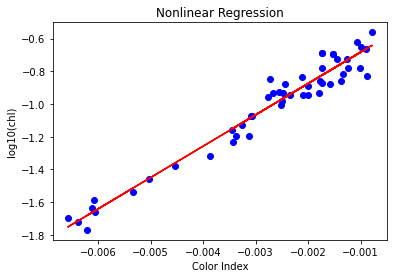

In [50]:
x = CI_subset
y = log_chla_subset

# Fitting Linear Regression to the dataset 
from sklearn.linear_model import LinearRegression 
lin = LinearRegression() 

lin.fit(x.reshape(-1,1), y) 

y_pred = lin.predict(x.reshape(-1,1))

# Visualising the Linear Regression results 
plt.scatter(x, y, color = 'blue') 
  
plt.plot(x, y_pred, color = 'red') 
plt.title('Nonlinear Regression') 
plt.xlabel('Color Index') 
plt.ylabel('log10(chl)') 
  
plt.show() 

These are the exact same coefficients as determined in the Hu et al paper

In [31]:
lin.intercept_, lin.coef_

(-0.49094242118012077, array([191.65891924]))

What is the R2 and the RMS?

In [32]:
r2 = r2_score(y, y_pred)
rms = np.sqrt(np.mean(np.square(((10**y - 10**y_pred) / 10**y)), axis=0))

print('R2 = ', r2)
print('RMS = ', rms)

R2 =  0.9515297407185628
RMS =  0.16515631505918116


Calculate the ChlCI (CI based chl estimates) using these coefficients:

In [33]:
ChlCI = 10**(lin.intercept_ + lin.coef_*CI_subset)

Check how good the predictions look along a linear relationship

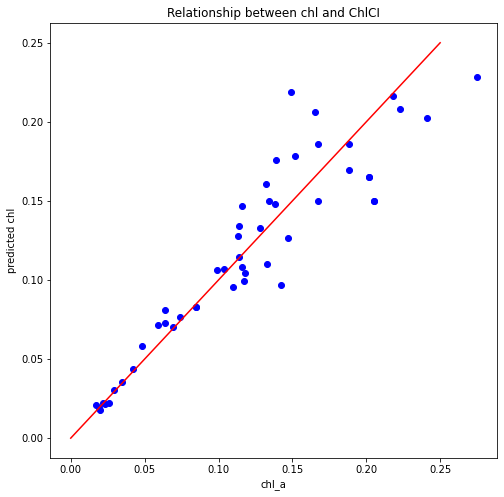

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(chla_subset, ChlCI, color = 'blue') 

ax.plot([0,.25],[0,.25], color='red')
  
ax.set_title('Relationship between chl and ChlCI') 
ax.set_xlabel(chl) 
ax.set_ylabel('predicted chl') 
  
fig.show() 

Make a plot that looks roughly like figure 3b from Hu et al

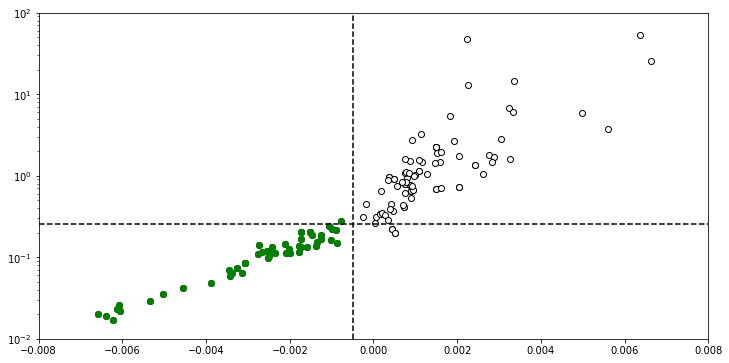

In [41]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(CI, df_chl[chl], color='white', edgecolors='black')
ax.scatter(CI[CI < -0.0005], df_chl[chl][CI < -0.0005], color='green')

ax.set_xlim(-0.008,.008)
ax.axvline(-.0005, linestyle='--', color='black')
ax.axhline(10**(lin.intercept_ + lin.coef_*(-0.0005)), linestyle='--', color='black')
ax.set_ylim(0.01, 100)
ax.set_yscale('log')